# Data Processing

For every sensor we regularly receive data in the format
$$ \left( a_x, a_y, a_z, g_x, g_y, g_z \right) $$
where $a_x, a_y, a_z$ are acceleration in their respective directions and $g_x, g_y, g_z$ are yaw, pitch and roll respectively.

In addition, for the training data we have information about the current state of tapping, if the finger is currenly on the table or not. In practice the predictions can be used to get a estimation for the current state of tapping.

## Parse Data

For training there are two ways for us to receive the necessary data
1. from records stored on the SD card on the main boards and
2. live through a serial interface when the main board is connected to the PC.

### From Record

The file that is stored on the main board is of some format `data-*.txt`. Every line is either of the already discussed format or contains `v` or `^` to indicate that the finger starts or stops touching the table respectively.

We start with parsing the file into a numpy array with suitable structure.

In [1]:
import numpy as np

FILENAME = "data3.txt"
SENSOR_COUNT = 6
SENSOR_VALUE_COUNT = 6

with open(FILENAME, 'r') as file:
    lines = file.read().strip().split('\n')

    # list of all readings
    all_readings = []
    # state of tapping
    pressing = False
    for line in lines:
        # check for change in state of tapping
        if "nt" in line: # TODO: change to "v"
            pressing = False
            continue
        elif "t" in line:
            pressing = True
            continue
            
        # one reading from all sensors (per line) flattened
        sensors = []
        for sensor_string in line.split(':'):
            # one sensor reading
            if sensor_string.count(';') != SENSOR_VALUE_COUNT-1:
                # set default values for non functional sensors
                sensors += [0, 0, 0, 0, 0, 0]
            else:
                sensors += [float(value) for value in sensor_string.split(';')]

        # add state of tapping to data entry
        sensors += [1 if pressing else 0]
        all_readings.append(sensors)

    data = np.array(all_readings)

### Through Serial

TODO

## Prepare Datasets

The datasets are formattings of the parsed data that can be passed to machine learning models as is.

To detect taps we try to strategies:
1. Detect press and release of taps separately. Easily extendable to holds.
2. Detect taps in one go.

The datasets will be saved using `joblib`.

In [19]:
from joblib import dump, load

# constants for press dataset
PRESS_BUFFER_SIZE = 3 # number of readings as input
PRESS_DATASET_FILENAME = "press_dataset.joblib"

# constats for release dataset
RELEASE_BUFFER_SIZE = 3
RELEASE_DATASET_FILENAME = "release_dataset.joblib"

### Press

This dataset will have `PRESS_BUFFER_SIZE` readings before and including the current reading in $X$ along with the tap state change (from not pressing to pressing) as output in $\mathbf{y}$.

In [6]:
PRESS_DATASET_SIZE = len(data)-(PRESS_BUFFER_SIZE-1)

# dataset declaration
press_dataset = (
    # X (input matrix)
    np.empty(shape = (
        PRESS_DATASET_SIZE,
        PRESS_BUFFER_SIZE * (SENSOR_COUNT * SENSOR_VALUE_COUNT)
    )),
    # y (output vector)
    np.empty(shape = PRESS_DATASET_SIZE)
)

# populate dataset with data
X = press_dataset[0]
y = press_dataset[1]
for index in np.arange(PRESS_DATASET_SIZE):
    for buffer_index in np.arange(PRESS_BUFFER_SIZE):
        size  = SENSOR_COUNT*SENSOR_VALUE_COUNT
        start = size*buffer_index
        end   = size*(buffer_index+1)
        X[index][start:end] = data[index+buffer_index][:size]
    # if change of tapping state in buffer (from not to tap)
    # set output to 1 otherwise 0
    y[index] = 1 if data[index+(PRESS_BUFFER_SIZE-1)][-1] - data[index+(PRESS_BUFFER_SIZE-2)][-1] == 1 else 0

# save dataset in PRPRESS_DATASET_FILENAME
dump(press_dataset, PRESS_DATASET_FILENAME)

['press_dataset.joblib']

### Release

This data set is like the press dataset but the output will only be one on a tap state change from pressing to not pressing (release).

In [4]:
RELEASE_DATASET_SIZE = len(data)-(RELEASE_BUFFER_SIZE-1)

# dataset declaration
release_dataset = (
    # X (input matrix)
    np.empty(shape = (
        RELEASE_DATASET_SIZE,
        RELEASE_BUFFER_SIZE * (SENSOR_COUNT * SENSOR_VALUE_COUNT)
    )),
    # y (output vector)
    np.empty(shape = RELEASE_DATASET_SIZE)
)

# populate dataset with data
X = release_dataset[0]
y = release_dataset[1]
for index in np.arange(RELEASE_DATASET_SIZE):
    for buffer_index in np.arange(RELEASE_BUFFER_SIZE):
        size  = SENSOR_COUNT*SENSOR_VALUE_COUNT
        start = size*buffer_index
        end   = size*(buffer_index+1)
        X[index][start:end] = data[index+buffer_index][:size]
    # if change of tapping state in buffer (from tap to not)
    # set output to 1 otherwise 0
    y[index] = 1 if data[index+(RELEASE_BUFFER_SIZE-1)][-1] - data[index+(RELEASE_BUFFER_SIZE-2)][-1] == -1 else 0

# save dataset in RELEASE_DATASET_FILENAME
dump(release_dataset, RELEASE_DATASET_FILENAME)

['release_dataset.joblib']

### Tap

TODO

# Machine Learning

## Dataset Preprocessing

### Dataset Splitting

To avoid overfitting in certain cases and generally improve validity the results the dataset will be split into a larger training dataset (67%) and a smaller testing dataset (33%). For now we will explicitly set `random_state` to improve reproducibility.

Additionally, to get a better idea of how practical the resulting model will be there will be two more datasets for scoring: one for the true positives rate, and one for the true negatives rate.

#### Press Dataset

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import dump, load

# full dataset
X, y = load(PRESS_DATASET_FILENAME)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42
)

# extended matrix
m = np.hstack((X_test, y_test.reshape((len(y_test),1))))

# only positives dataset
X_positive = m[m[:,-1] == 1, :-1]
y_positive = m[m[:,-1] == 1, -1]

# only negatives dataset
X_negative = m[m[:,-1] == 0, :-1]
y_negative = m[m[:,-1] == 0, -1]

#### Release Dataset

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import dump, load

# full dataset
X, y = load(RELEASE_DATASET_FILENAME)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42
)

# extended matrix
m = np.hstack((X_test, y_test.reshape((len(y_test),1))))

# only positives dataset
X_positive = m[m[:,-1] == 1, :-1]
y_positive = m[m[:,-1] == 1, -1]

# only negatives dataset
X_negative = m[m[:,-1] == 0, :-1]
y_negative = m[m[:,-1] == 0, -1]

## Helper

Some potentially helpful helper functions. Collecting them here hopefully also increases readability.

### Model Pipeline

- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_pipeline(clf):
    return make_pipeline(StandardScaler(), clf)

### Scoring

In [23]:
# given a classifier, return accuracy score for each given dataset
def score_classifier(clf, datasets):
    scores = np.empty(shape=(len(datasets),))
    for index, (X, y) in enumerate(datasets):
        scores[index] = clf.score(X, y)
    return scores

## Logistic Regression

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [8]:
from sklearn.linear_model import LogisticRegression
from fastprogress.fastprogress import progress_bar
import matplotlib.pyplot as plt

# prepare and train classifier with given dataset and hyperparameters
def lr_get_press_classifier(X, y, press_weight = 1):
    press_classifier = get_pipeline(LogisticRegression(class_weight = {1:press_weight}))
    press_classifier.fit(X, y)
    return press_classifier

# given weight range and kernel, return for each dataset return
# score list according to the weight range
def lr_get_scores(weight_range):
    scores = np.empty(shape=(3, len(weight_range)))
    prog_bar = progress_bar(list(enumerate(weight_range)))
    for index, weight in prog_bar:
        prog_bar.comment = f"weight: {weight}"
        clf = lr_get_press_classifier(X_train, y_train, press_weight = weight)
        scores[:,index] = score_classifier(clf, [
            (X_test,     y_test),
            (X_positive, y_positive),
            (X_negative, y_negative)
        ])
    return scores

I don't really see any hyperparameters I think are worth tuning right now, except for the class weight.

### Press Dataset

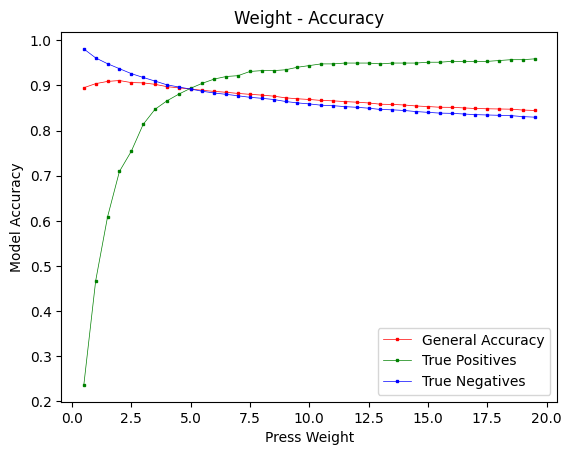

In [20]:
weight_range = np.arange(.5, 20., .5)
scores = lr_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

### Release Dataset

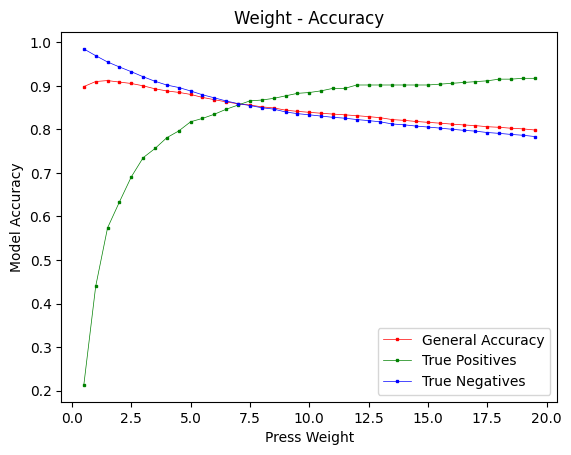

In [9]:
weight_range = np.arange(.5, 20., .5)
scores = lr_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Decision Tree Learning

https://scikit-learn.org/stable/modules/tree.html#tree-classification

The goal for decision tree learning is to create a tree that at every node splits according to some threshold value for some feature chosen scored by the criterion. The algorithm creates further nodes for the tree as long as some condition is not fulfilled. We use the `scikit-learn` implementation.

In [10]:
from sklearn import tree
from fastprogress.fastprogress import progress_bar
import matplotlib.pyplot as plt

# prepare and train classifier with given dataset and hyperparameters
def dtl_get_press_classifier(X, y, press_weight = 1, criterion = "gini"):
    press_classifier = get_pipeline(tree.DecisionTreeClassifier(class_weight = {1:press_weight}, criterion = criterion))
    press_classifier.fit(X, y)
    return press_classifier

# given weight range and kernel, return for each dataset return
# score list according to the weight range
def dtl_get_scores(weight_range, criterion):
    scores = np.empty(shape=(3, len(weight_range)))
    prog_bar = progress_bar(list(enumerate(weight_range)))
    for index, weight in prog_bar:
        prog_bar.comment = f"weight: {weight}"
        clf = dtl_get_press_classifier(X_train, y_train, press_weight = weight, criterion = criterion)
        scores[:,index] = score_classifier(clf, [
            (X_test,     y_test),
            (X_positive, y_positive),
            (X_negative, y_negative)
        ])
    return scores

We will proceed with hyperparameter tuning for every dataset. As the first hyperparameter we try different criterions for measuring the quality of a split. The four options `scikit-learn` provides us with are:
1. gini
2. entropy
3. log_loss

Furthermore, we will vary the assigned class weights for every kernel.

### Press Dataset

#### Gini Criterion

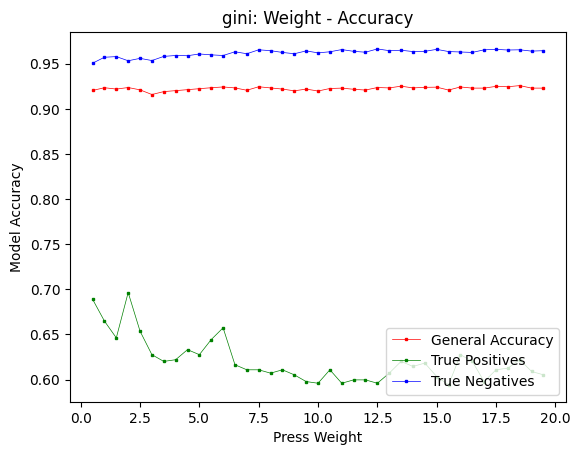

In [16]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "gini") # gini criterion

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Entropy Criterion

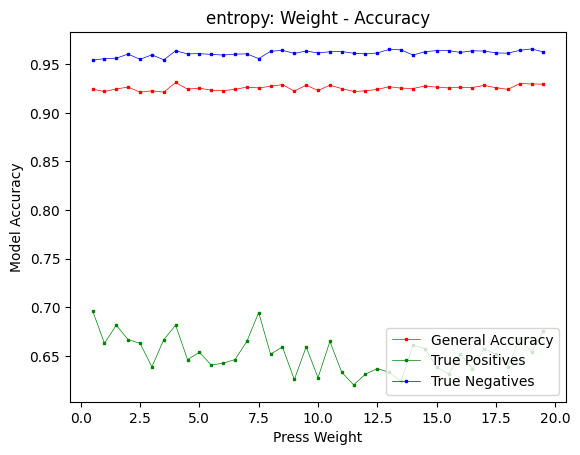

In [17]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "entropy") # entropy criterion

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("entropy: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Log_loss Criterion

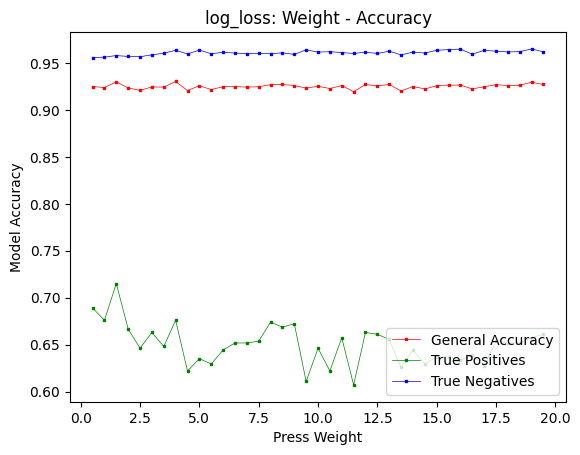

In [18]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "log_loss") # log_loss criterion

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("log_loss: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

### Release Dataset

#### Gini Criterion

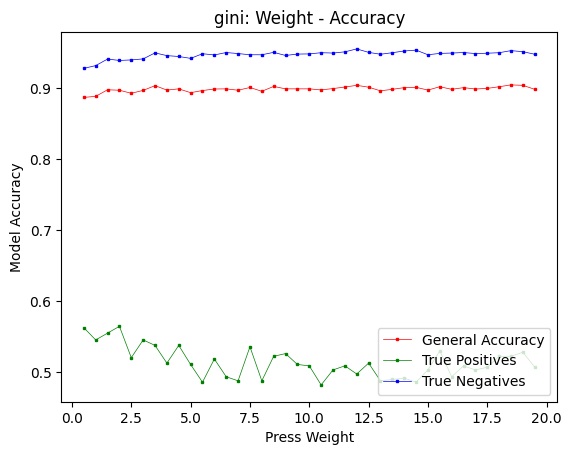

In [11]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "gini") # gini kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Entropy Criterion

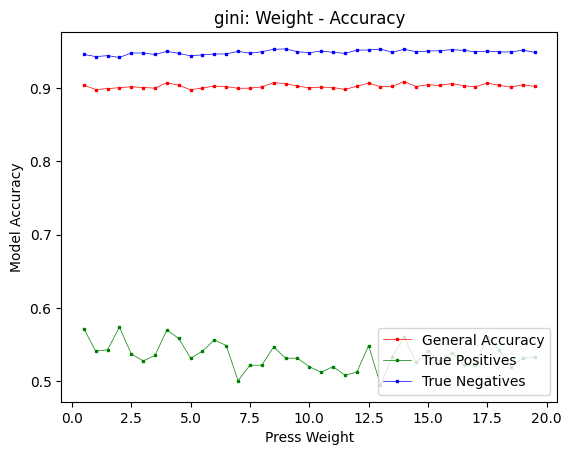

In [12]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "entropy") # entropy kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Log_loss Criterion

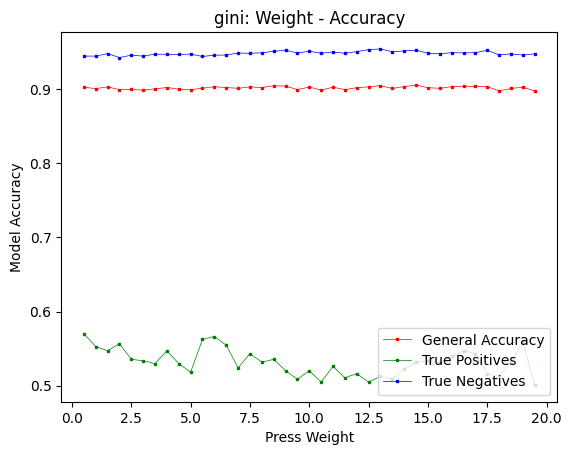

In [13]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "log_loss") # log_loss kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Random Forest

A Random Forest consist of multiple Decision Trees trained with randomised input parts the final prediction of a Random Forest is the averaged prediction of the individual classifiers.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from fastprogress.fastprogress import progress_bar
import matplotlib.pyplot as plt

# prepare and train classifier with given dataset and hyperparameters
def rfc_get_press_classifier(X, y, press_weight = 1):
    press_classifier = get_pipeline(RandomForestClassifier(class_weight = {1:press_weight}))
    press_classifier.fit(X, y)
    return press_classifier

# given weight range and kernel, return for each dataset return
# score list according to the weight range
def rfc_get_scores(weight_range):
    scores = np.empty(shape=(3, len(weight_range)))
    prog_bar = progress_bar(list(enumerate(weight_range)))
    for index, weight in prog_bar:
        prog_bar.comment = f"weight: {weight}"
        clf = rfc_get_press_classifier(X_train, y_train, press_weight = weight)
        scores[:,index] = score_classifier(clf, [
            (X_test,     y_test),
            (X_positive, y_positive),
            (X_negative, y_negative)
        ])
    return scores

We will only consider the `class_weight` hyperparameter.

### Press Dataset

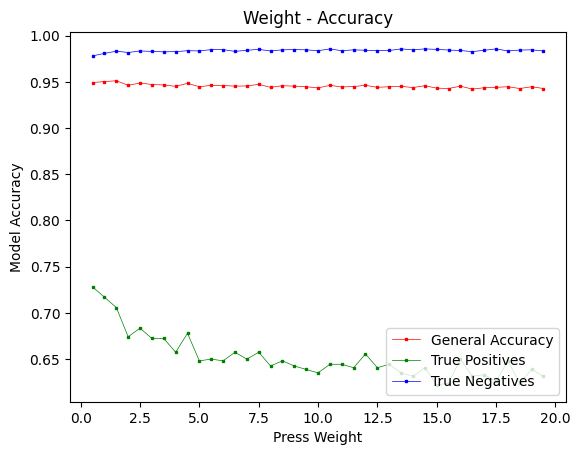

In [52]:
weight_range = np.arange(.5, 20., .5)
scores = rfc_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

### Release Dataest

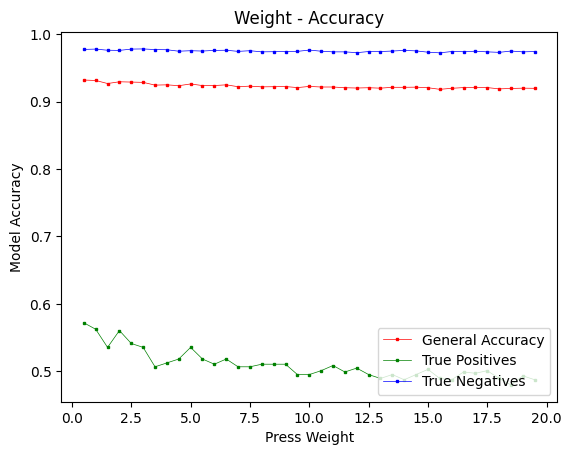

In [15]:
weight_range = np.arange(.5, 20., .5)
scores = rfc_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Support Vector Machine (SVM)

https://scikit-learn.org/stable/modules/svm.html

A support vector machine tries to separate the training data with a hyperplane optimally using the features as coordinates. We will use the `scikit-learn` implementation. We also define some functions to more easily assess the models and improve readability.

In [24]:
from sklearn import svm
from fastprogress.fastprogress import progress_bar
import matplotlib.pyplot as plt

# prepare and train classifier with given dataset and hyperparameters
def svm_get_press_classifier(X, y, press_weight = 1, kernel = "rbf"):
    press_classifier = get_pipeline(svm.SVC(class_weight = {1:press_weight}, kernel = kernel))
    press_classifier.fit(X, y)
    return press_classifier

# given weight range and kernel, return for each dataset return
# score list according to the weight range
def svm_get_scores(weight_range, kernel):
    scores = np.empty(shape=(3, len(weight_range)))
    prog_bar = progress_bar(list(enumerate(weight_range)))
    for index, weight in prog_bar:
        prog_bar.comment = f"weight: {weight}"
        clf = svm_get_press_classifier(X_train, y_train, press_weight = weight, kernel = kernel)
        scores[:,index] = score_classifier(clf, [
            (X_test,     y_test),
            (X_positive, y_positive),
            (X_negative, y_negative)
        ])
    return scores

We will now try to tune the hyperparameters to improve the performance of the models for every data set. The first hyperparameter that we consider is the kernel `scikit-learn` uses for its support vector machine implementation. There are four options:
1. linear
2. polynomial
3. rbf
4. sigmoid

For every kernel we will then further tune the weight that is assigned to the different output classes.

### Press Dataset

#### Linear Kernel

The linear kernel seems to be really slow. Even for our smallest dataset fitting with a linear kernel did not terminate within a reasonable (short) amount of time. Thus we have decided to leave it out for now.

#### Polynomial Kernel

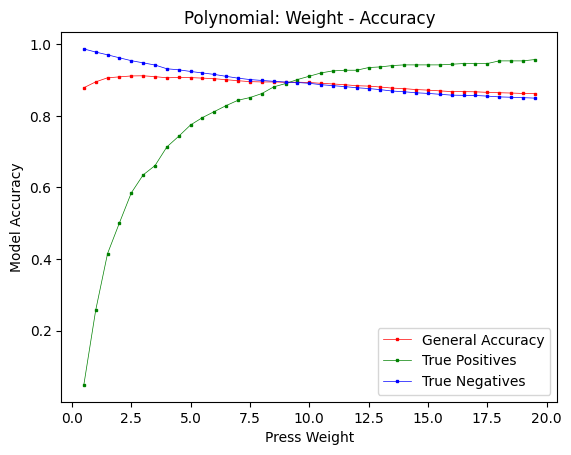

In [10]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "poly") # polynomial kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Polynomial: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Radial Basis Function (RBF) Kernel

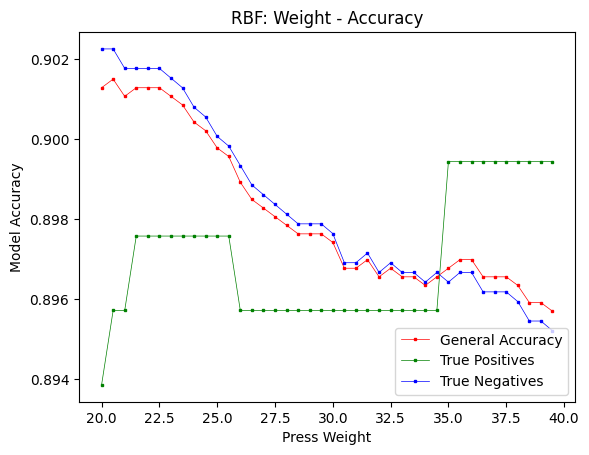

In [14]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "rbf") # rbf kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("RBF: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Sigmoid Kernel

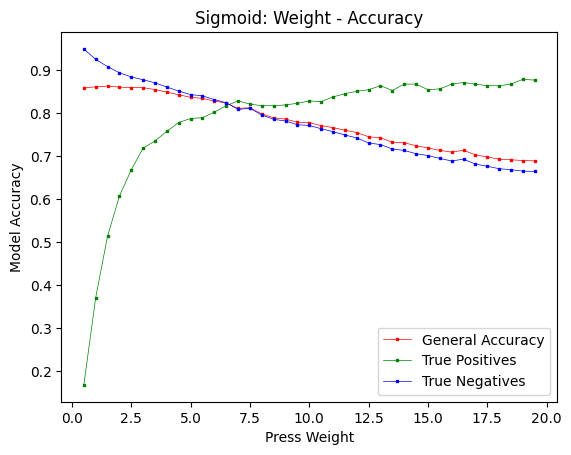

In [12]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "sigmoid") # sigmoid kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Sigmoid: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

### Release Dataset

#### Linear Kernel

The linear kernel will not be considered for the reasons stated above.

#### Polynomial Kernel

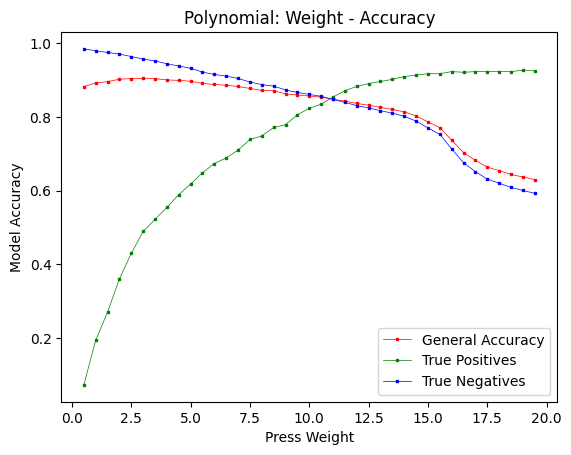

In [17]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "poly") # polynomial kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Polynomial: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Radial Basis Function (RBF) Kernel

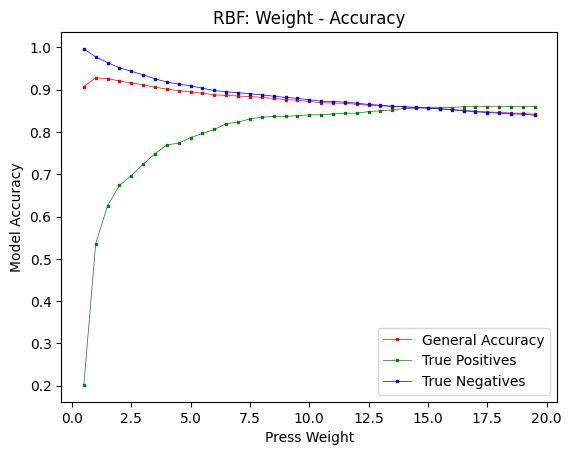

In [25]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "rbf") # rbf kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("RBF: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Sigmoid Kernel

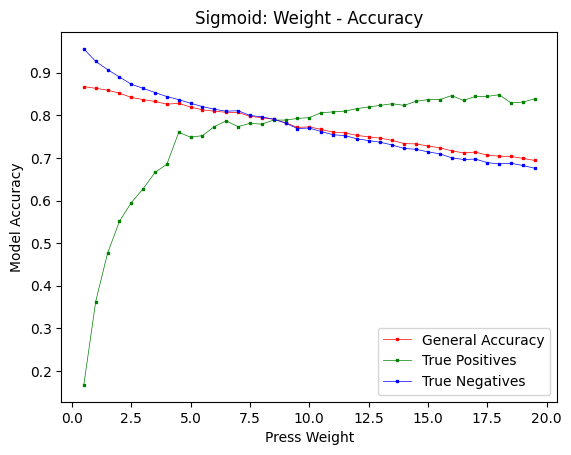

In [26]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "sigmoid") # sigmoid kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Sigmoid: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## $k$-Mean Classifier

https://scikit-learn.org/stable/modules/neighbors.html#classification

For some distance function get the $k$ nearest training dataset entries for the input and perform a majority vote to determine the corresponding output.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from fastprogress.fastprogress import progress_bar
import matplotlib.pyplot as plt

# prepare and train classifier with given dataset and hyperparameters
def knc_get_press_classifier(X, y, neighbors=5, weights='uniform'):
    press_classifier = get_pipeline(KNeighborsClassifier(n_neighbors=neighbors, weights=weights))
    press_classifier.fit(X, y)
    return press_classifier

# given weight range and kernel, return for each dataset return
# score list according to the weight range
def knc_get_scores(neighbors_range, weights):
    scores = np.empty(shape=(3, len(neighbors_range)))
    prog_bar = progress_bar(list(enumerate(neighbors_range)))
    for index, neighbors in prog_bar:
        prog_bar.comment = f"weight: {neighbors}"
        clf = knc_get_press_classifier(X_train, y_train, neighbors=neighbors, weights=weights)
        scores[:,index] = score_classifier(clf, [
            (X_test,     y_test),
            (X_positive, y_positive),
            (X_negative, y_negative)
        ])
    return scores

The hyperparameters we consider are the weight function used and how many neighbors to consider when voting. The weight functions are:
1. uniform
2. distance

### Press Dataset

#### Uniform Weighting

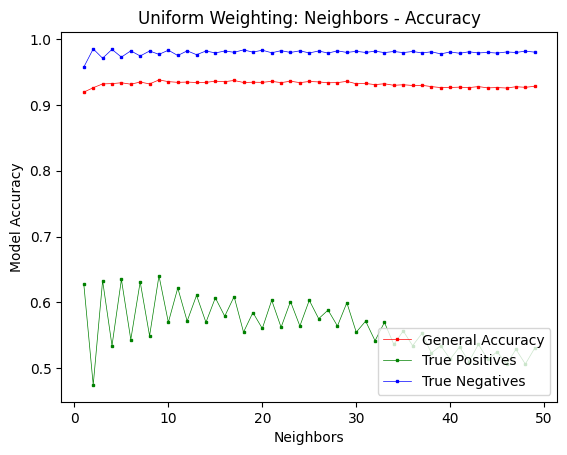

In [29]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='uniform')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Uniform Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Distance Weighting

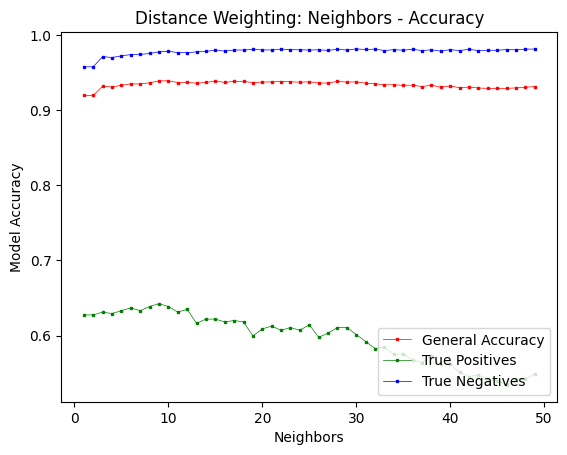

In [28]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='distance')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Distance Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

### Release Dataset

#### Uniform Weighting

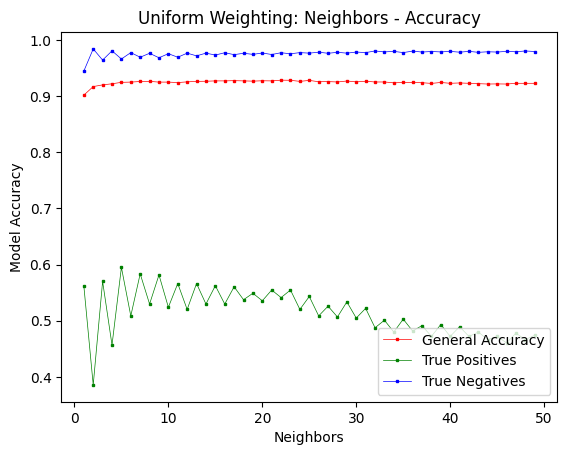

In [29]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='uniform')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Uniform Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Distance Weighting

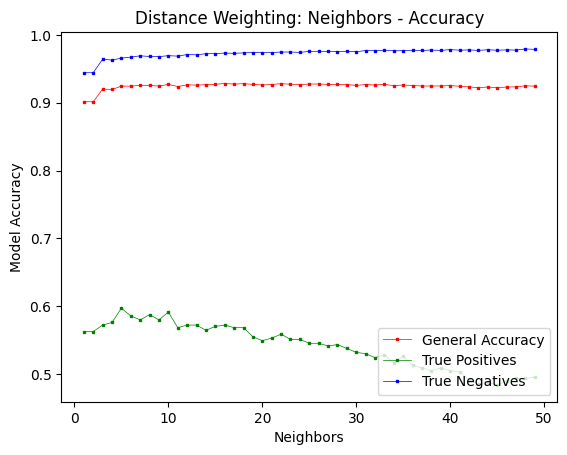

In [30]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='distance')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Distance Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()